# Abnormality Detection in Bone X-Rays

> *Deep Learning*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

##### *Description*

Given a study containing X-Ray images, build a deep learning model that decides if the study is normal or abnormal. You must use at least 2 different architectures, one with your own CNN model (e.g., you can use a model similar to the CNN of the previous project) and one with a popular pre-trained CNN model (e.g., VGG-19, ResNet, etc.). Use the MURA dataset to train and evaluate your models. More information about the task and the dataset can be found at <a href="https://stanfordmlgroup.github.io/competitions/mura/">https://stanfordmlgroup.github.io/competitions/mura/</a>. To download the dataset you must first fill out a form.

### 1. Imports

In [11]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K
import gc
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import MaxPool2D,Dropout,GlobalAveragePooling2D,GlobalMaxPooling2D,Flatten,Dropout,Dense, \
                 Activation,SpatialDropout2D,AvgPool2D,Input, Conv2D,BatchNormalization,LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.metrics import AUC, BinaryAccuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
                            roc_auc_score,classification_report,precision_recall_curve,confusion_matrix
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model  

### 2. Data

The MURA dataset is a large-scale dataset of musculoskeletal radiographs that was released by Stanford University in 2017. The acronym "MURA" stands for "musculoskeletal radiographs" and the dataset contains over 40,000 digital X-ray images covering seven different body parts, including the wrist, elbow, shoulder, finger, hip, knee, and ankle.

The purpose of the MURA dataset is to enable the development of machine learning models that can automatically detect abnormalities in musculoskeletal radiographs. This is a challenging task because abnormalities can be subtle and difficult for even trained human radiologists to detect.

The MURA dataset has become a popular benchmark for evaluating the performance of deep learning models in musculoskeletal radiograph analysis. It has been used in a number of research studies and competitions to develop and test algorithms for detecting fractures, dislocations, and other abnormalities in X-ray images.

#### 2.1 Load and plot the data

In [28]:
dir_mura = "./Data/MURA-v1.1"
#dir_mura = "C:/Users/anakos/Desktop/Data Science/Deep Learning Prv/MURA-v1.1"

# Read the metadata files
df_train = pd.read_csv(os.path.join(dir_mura, "train_image_paths.csv"), 
                                names=["image_path"], header=None)

df_valid = pd.read_csv(os.path.join(dir_mura, "valid_image_paths.csv"), 
                                names=["image_path"], header=None)


# Extract class (positive/negative) from the column 'image_path'
df_train['class'] = (df_train.image_path.str.extract('study.*_(positive|negative)'))
df_valid['class'] = (df_valid.image_path.str.extract('study.*_(positive|negative)'))

# create a description of the study of each image
df_train['description'] = df_train.image_path.apply(lambda x: '_'.join(x.split('/')[2:5])[3:])
df_valid['description'] = df_valid.image_path.apply(lambda x: '_'.join(x.split('/')[2:5])[3:])

# get the type of each study (e.g., elbow, shoulder, etc.)
df_train['type'] = df_train.description.apply(lambda x: x.split('_')[0])
df_valid['type'] = df_valid.description.apply(lambda x: x.split('_')[0])

# Update the image paths to include the full directory path
#df_train['image_path'] = df_train['image_path'].map(lambda x: os.path.join("C:/Users/anakos/Desktop/Data Science Prv/Deep Learning/", x))
#df_valid['image_path'] = df_valid['image_path'].map(lambda x: os.path.join("C:/Users/anakos/Desktop/Data Science Prv/Deep Learning/", x))

# Update the image paths to include the full directory path
df_train['image_path'] = df_train['image_path'].map(lambda x: os.path.join("./Data/", x))
df_valid['image_path'] = df_valid['image_path'].map(lambda x: os.path.join("./Data/", x))

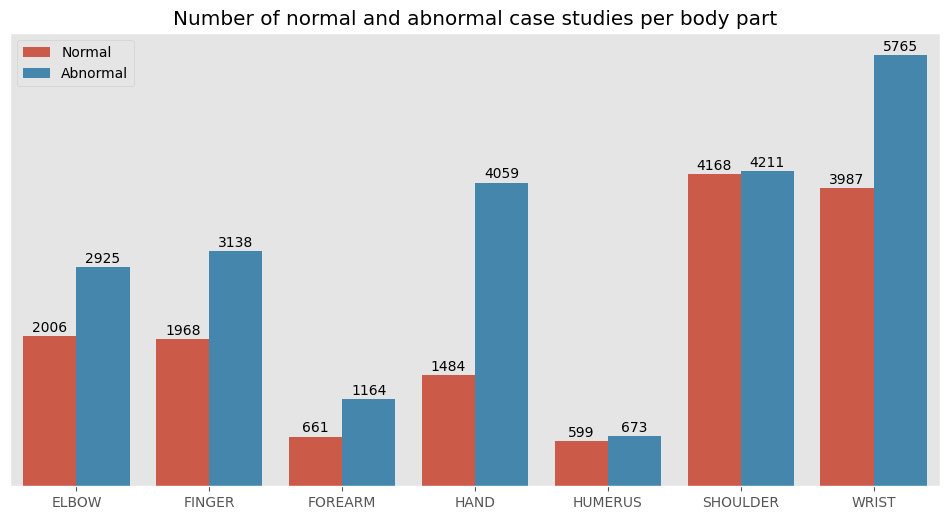

In [9]:
# Set the size and resolution of the figure
plt.figure(figsize=(12, 6), dpi=100)

# Create a count plot using Seaborn, sorting the 'type' variable
ax = sns.countplot(data=df_train, x=df_train['type'].sort_values(), hue=df_train['class'])

# Add labels to the bars with counts, using padding for better visibility
ax.bar_label(ax.containers[0], padding=1)
ax.bar_label(ax.containers[1], padding=1)

# Remove x-axis and y-axis labels and ticks for clarity
plt.xlabel(None)
plt.ylabel(None)
plt.yticks([])

# Set the title of the plot
plt.title('Number of normal and abnormal case studies per body part')

# Add a legend with labels 'Normal' and 'Abnormal'
plt.legend(loc=0, labels=['Normal', 'Abnormal'])

# Display the plot
plt.show()

#### 2.2 Data Preprocessing

To improve the performance in image recognition, we will use the **image data augmentation** technique. 

`ImageDataGenerator` is a crucial component for data preprocessing. It serves a dual purpose: first, to apply real-time data augmentation during training, enhancing the model's ability to generalize by exposing it to a variety of image transformations like rotation, zooming, and flipping. Second, it normalizes pixel values of the images to a scale between 0 and 1, which aids in model convergence by ensuring consistent input data ranges. The `flow_from_dataframe` method then utilizes the configured `ImageDataGenerator` to generate a continuous flow of preprocessed image data from the training and validation dataframes. This flow of data is essential for training and evaluating deep learning models efficiently, contributing to improved model performance and generalization on unseen data.

In [4]:
# Create an ImageDataGenerator for data augmentation and normalization
datagen = ImageDataGenerator(rescale = 1. / 255)

# Create a flow from the training dataframe for model training
trainset = datagen.flow_from_dataframe(
    directory = dir_mura,
    dataframe=df_train,
    x_col="image_path",
    y_col="class",
    target_size=(224, 224),
    class_mode="binary")

# Create a flow from the validation dataframe for model evaluation
validset = datagen.flow_from_dataframe(
    directory = dir_mura,
    dataframe=df_valid,
    x_col="image_path",
    y_col="class",
    target_size=(224, 224),
    class_mode="binary")

Found 36808 validated image filenames belonging to 2 classes.
Found 3197 validated image filenames belonging to 2 classes.


### 3. Define Useful Functions

#### 3.1 Plot Functions

In [23]:
def print_results(hs, evaluate_model, metric='val_accuracy'):
    # Find the index and value of the maximum metric value in the history
    min_val_loss, idx = max((val, idx) for (idx, val) in enumerate(hs.history[metric]))

    # Print information about the best epoch
    print('Best Epoch: ', idx + 1)
    print("---")

    # Print training metrics at the best epoch
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][idx]))
    print("Train Accuracy : {0:.5f}".format(hs.history['accuracy'][idx]))
    print("Train Precision: {0:.5f}".format(hs.history['precision'][idx]))
    print("Train Recall   : {0:.5f}".format(hs.history['recall'][idx]))
    print("Train AUC      : {0:.5f}".format(hs.history['roc_auc'][idx]))

    print("---")

    # Print validation metrics at the best epoch
    print("Validation Loss     : {0:.5f}".format(hs.history['val_loss'][idx]))
    print("Validation Accuracy : {0:.5f}".format(hs.history['val_accuracy'][idx]))
    print("Validation Precision: {0:.5f}".format(hs.history['val_precision'][idx]))
    print("Validation Recall   : {0:.5f}".format(hs.history['val_recall'][idx]))
    print("Validation AUC      : {0:.5f}".format(hs.history['val_roc_auc'][idx]))


def plot_history(hs, epochs, metric, ticks):
    # Print an empty line for better visual separation
    print()

    # Set the style and size of the plot
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 16

    # Clear the current plot
    plt.clf()

    # Iterate through each label in the history dictionary
    for label in hs:
        # Plot the training and validation metric values for each label
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)

    # Set x-axis ticks at intervals of 10% of total epochs
    x_ticks = np.arange(0, epochs + 1, epochs / ticks)
    x_ticks[0] += 1
    plt.xticks(x_ticks)

    # Set y-axis limit based on the metric being plotted
    plt.ylim((0, 1)) if metric == 'loss' else plt.ylim((0, 100))

    # Set x-axis and y-axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric == 'loss' else 'Accuracy')

    # Display a legend
    plt.legend()

    # Show the plot
    plt.show()

#### 3.2 Clean Function

In [3]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

### 4. Model Architectures (CNNs)

In this section we will create different architectures of a **Convolutional Neural Network**. We will focus especially on the number of hidden layers and the optimizers.

#### List of metrics to monitor during training

In [5]:
metric_list = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC")
]

#### 4.1 **First CNN Model**

> **Convolution layers:** Three <br>
> **Activation function:** Relu and Sigmoid(output) <br>
> **Dropout:** 0.2 <br>
> **Loss function:** Binary Cross Entropy <br>
> **Optimizer:** Adam, Learning Rate = 0.0001 <br>

##### 4.1.1 Creation

In [24]:
# Set random seeds for reproducibility
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Flatten, Dense

tf.random.set_seed(999)

# Define the input shape for the model
input_shape = (224, 224, 3)

# Create a sequential model
model = Sequential(name="Three_Layer_CNN")

# Add the input layer
model.add(Conv2D(
    filters=8 * 2,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='he_uniform',
    activation='relu',
    input_shape=input_shape,
    name='Conv2D-1'
))

model.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-1'
))

model.add(Dropout(rate=0.2, name='Dropout-1'))

model.add(Conv2D(
    filters=8 * 4,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='GlorotUniform',
    activation='relu',
    name='Conv2D-2'
))

model.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-2'
))

model.add(Dropout(rate=0.2, name='Dropout-2'))

model.add(Conv2D(
    filters=8 * 8,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='GlorotUniform',
    activation='relu',
    name='Conv2D-3'
))

model.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-3'
))

model.add(Dropout(rate=0.2, name='Dropout-3'))

model.add(Flatten(name='Flatten'))

# Output Layer
model.add(Dense(units=1, activation='sigmoid', name='Output'))

# Display model summary
model.summary()

Model: "Three_Layer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 112, 112, 16)      0         
                                                                 
 Dropout-1 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 MaxPool2D-2 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                                 
 Dropout-2 (Dropout)         (None, 56, 56, 32)        0         
                                                                 
 Conv2D-3 (Conv2D)           (None, 56, 56, 64)    

##### 4.1.2 Training

In [8]:
# Define a callback to save the best model weights based on validation accuracy
callbacks = [ModelCheckpoint(
    filepath='./Checkpoints/best_weights_Three_Layer_CNN_Model.h5',  # Filepath to save the best weights
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',  # Mode to maximize validation accuracy
    save_best_only=True,  # Save only the best weights
    save_weights_only=True  # Save only the weights (not the entire model)
)]

# Define early stopping callback to prevent overfitting and restore the best weights
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",  # Monitor validation accuracy for early stopping
    verbose=1,  # Print messages about early stopping
    patience=10,  # Number of epochs with no improvement after which training will be stopped
    mode="max",  # Mode to maximize validation accuracy
    restore_best_weights=True  # Restore the weights from the epoch with the best value of the monitored quantity
)

# Define the optimizer 
optimizer = Adam(learning_rate=0.0001)

# Compile the model with binary crossentropy loss and specified metrics
model.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=metric_list)

# Train the model
hs = model.fit(
    trainset, 
    validation_data=validset,
    epochs=100, 
    verbose=1,  
    callbacks=[callbacks, early_stopping],  
    batch_size=64  
)

Epoch 1/100
1151/1151 [==============================] - 498s 432ms/step - loss: 0.6653 - accuracy: 0.5925 - precision: 0.4786 - recall: 0.0947 - roc_auc: 0.5759 - val_loss: 0.6863 - val_accuracy: 0.5436 - val_precision: 0.5962 - val_recall: 0.1438 - val_roc_auc: 0.5941
Epoch 2/100
1151/1151 [==============================] - 477s 415ms/step - loss: 0.6509 - accuracy: 0.6111 - precision: 0.5534 - recall: 0.1939 - roc_auc: 0.6203 - val_loss: 0.6828 - val_accuracy: 0.5533 - val_precision: 0.6085 - val_recall: 0.1869 - val_roc_auc: 0.6079
Epoch 3/100
1151/1151 [==============================] - 477s 414ms/step - loss: 0.6413 - accuracy: 0.6247 - precision: 0.5756 - recall: 0.2712 - roc_auc: 0.6442 - val_loss: 0.6704 - val_accuracy: 0.5834 - val_precision: 0.6247 - val_recall: 0.3242 - val_roc_auc: 0.6300
Epoch 4/100
1151/1151 [==============================] - 476s 414ms/step - loss: 0.6317 - accuracy: 0.6366 - precision: 0.5925 - recall: 0.3227 - roc_auc: 0.6635 - val_loss: 0.6690 - val_

##### 4.1.3 Evaluation

Best Epoch:  25
---
Train Loss     : 0.48897
Train Accuracy : 0.76013
Train Precision: 0.73833
Train Recall   : 0.62946
Train AUC      : 0.83371
---
Validation Loss     : 0.68834
Validation Accuracy : 0.64936
Validation Precision: 0.68507
Validation Recall   : 0.49477
Validation AUC      : 0.69552



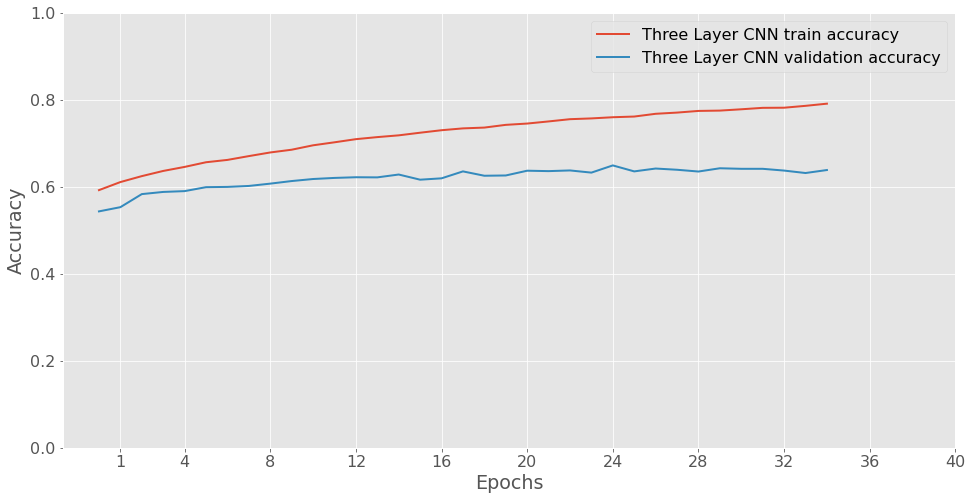

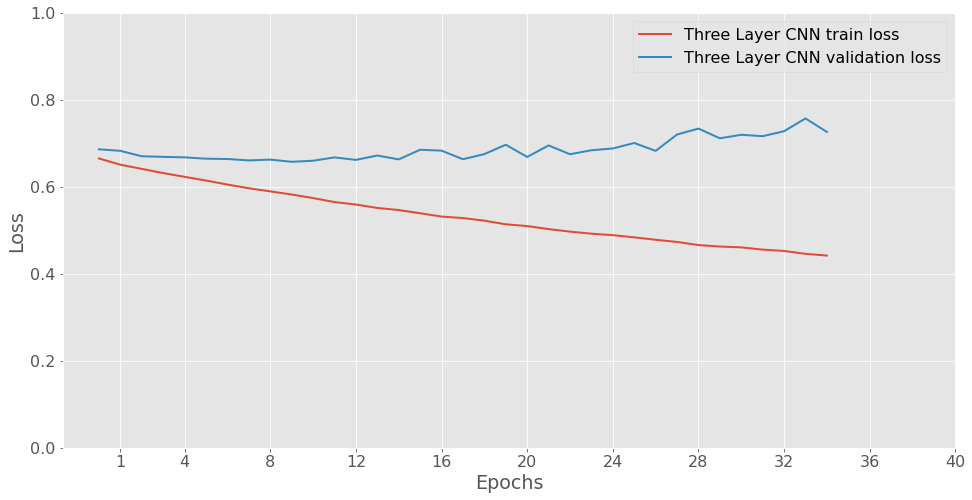

In [39]:
model.load_weights('./Checkpoints/best_weights_Three_Layer_CNN_Model.h5')

score = model.evaluate(validset,verbose = 0)

print_results(hs, score)

plot_history(hs = {'Three Layer CNN': hs}, epochs = 40, metric = 'accuracy', ticks = 10)
plot_history(hs = {'Three Layer CNN': hs}, epochs = 40, metric = 'loss', ticks = 10)

##### *Remarks*

- Training stoped at **epoch 35** due to the early stopping. It is evident that, as the training progresses, the model begins to exhibit signs of overfitting.

- The model attains a validation accuracy of **64.9%**, which was acheived at **epoch 25**. 

#### 4.2 **Second CNN Model**

> **Convolution layers:** Four <br>
> **Dense layers:** One <br>
> **Activation function:** Relu and Sigmoid(output) <br>
> **Dropout:** 0.2 (0.25 after the last dense layer) <br>
> **Batch Normilization:** After each convolutional layer
> **Loss function:** Binary Cross Entropy <br>
> **Optimizer:** Adam <br>

##### 4.2.1 Creation

In [26]:
# Set random seeds for reproducibility
tf.random.set_seed(999)

# Define the input shape for the model
input_shape = (224, 224, 3)

# Create a sequential model
model_2 = Sequential(name="Four_Layer_CNN")

# Add the input layer
model_2.add(Input(shape=input_shape, name='Input'))

# Block 1
model_2.add(Conv2D(
    filters=8*2,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='GlorotUniform',
    activation='relu',
    name='Conv2D-1'))

model_2.add(BatchNormalization(name='Normalization-1'))

model_2.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-1'))

model_2.add(Dropout(rate=0.2, name='Dropout-1'))

# Block 2
model_2.add(Conv2D(
    filters=8*4,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='GlorotUniform',
    activation='relu',
    name='Conv2D-2'))

model_2.add(BatchNormalization(name='Normalization-2'))

model_2.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-2'))

model_2.add(Dropout(rate=0.2, name='Dropout-2'))

# Block 3
model_2.add(Conv2D(
    filters=8*8,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='GlorotUniform',
    activation='relu',
    name='Conv2D-3'))

model_2.add(MaxPool2D(
    pool_size=(2, 2), 
    strides=(2, 2),
    padding='same', 
    name='MaxPool2D-3'))

model_2.add(BatchNormalization(name='Normalization-3'))

model_2.add(Dropout(rate=0.2, name='Dropout-3'))

# Block 4
model_2.add(Conv2D(
    filters=8*16,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    dilation_rate=(1, 1),
    kernel_initializer='GlorotUniform',
    activation='relu',
    name='Conv2D-4'))

model_2.add(MaxPool2D(
    pool_size=(2, 2),
    strides=(2, 2),
    padding='same',
    name='MaxPool2D-4'))

model_2.add(BatchNormalization(name='Normalization-4'))

model_2.add(Dropout(rate=0.2, name='Dropout-4'))

# Flatten the output
model_2.add(Flatten(name='Flatten'))

# Fully connected layer
model_2.add(Dense(units=128, activation='relu', name='Dense-1'))
model_2.add(Dropout(rate=0.25, name='Dropout-5'))

# Output layer
model_2.add(Dense(units=1, activation='sigmoid', name='Output'))

# Display model summary
model_2.summary()

Model: "Four_Layer_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D-1 (Conv2D)           (None, 224, 224, 16)      448       
                                                                 
 Normalization-1 (BatchNorma  (None, 224, 224, 16)     64        
 lization)                                                       
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 112, 112, 16)      0         
                                                                 
 Dropout-1 (Dropout)         (None, 112, 112, 16)      0         
                                                                 
 Conv2D-2 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 Normalization-2 (BatchNorma  (None, 112, 112, 32)     128       
 lization)                                          

##### 4.2.2 Training

In [34]:
# Define callbacks for model training
callbacks = [
    # ModelCheckpoint saves the best model weights based on validation accuracy
    ModelCheckpoint(
        filepath='./Checkpoints/best_weights_Four_Layer_CNN_Model.h5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=True
    ),
    # EarlyStopping stops training if the validation accuracy does not improve after 'patience' epochs
    EarlyStopping(
        monitor="val_accuracy",
        verbose=1,
        patience=5,
        mode="max",
        restore_best_weights=True
    )
]

# Define optimizer
optimizer = Adam()

# Compile the model with binary crossentropy loss and additional metrics
model_2.compile(optimizer=optimizer, loss=BinaryCrossentropy(), metrics=metric_list)

# Train the model 
hs_2 = model_2.fit(
    trainset,
    validation_data=validset,
    epochs=100,
    verbose=1,
    callbacks=[callbacks, early_stopping],
    batch_size=64
)

Epoch 1/100
1151/1151 [==============================] - 745s 646ms/step - loss: 0.7169 - accuracy: 0.5997 - precision: 0.5863 - recall: 0.0804 - roc_auc: 0.5879 - val_loss: 0.7298 - val_accuracy: 0.5214 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_roc_auc: 0.5268
Epoch 2/100
1151/1151 [==============================] - 749s 651ms/step - loss: 0.6580 - accuracy: 0.5961 - precision: 0.5157 - recall: 0.0055 - roc_auc: 0.6025 - val_loss: 0.6884 - val_accuracy: 0.5221 - val_precision: 1.0000 - val_recall: 0.0013 - val_roc_auc: 0.6060
Epoch 3/100
1151/1151 [==============================] - 754s 655ms/step - loss: 0.6479 - accuracy: 0.6010 - precision: 0.5835 - recall: 0.0442 - roc_auc: 0.6261 - val_loss: 0.6783 - val_accuracy: 0.5324 - val_precision: 0.6882 - val_recall: 0.0418 - val_roc_auc: 0.6321
Epoch 4/100
1151/1151 [==============================] - 752s 654ms/step - loss: 0.6438 - accuracy: 0.6127 - precision: 0.6382 - recall: 0.0958 - roc_auc: 0.6365 - val_loss: 0.731

##### 4.2.3 Evaluation

Best Epoch:  14
---
Train Loss     : 0.50294
Train Accuracy : 0.73902
Train Precision: 0.78753
Train Recall   : 0.48497
Train AUC      : 0.80827
---
Validation Loss     : 0.64413
Validation Accuracy : 0.67063
Validation Precision: 0.75896
Validation Recall   : 0.45686
Validation AUC      : 0.73742



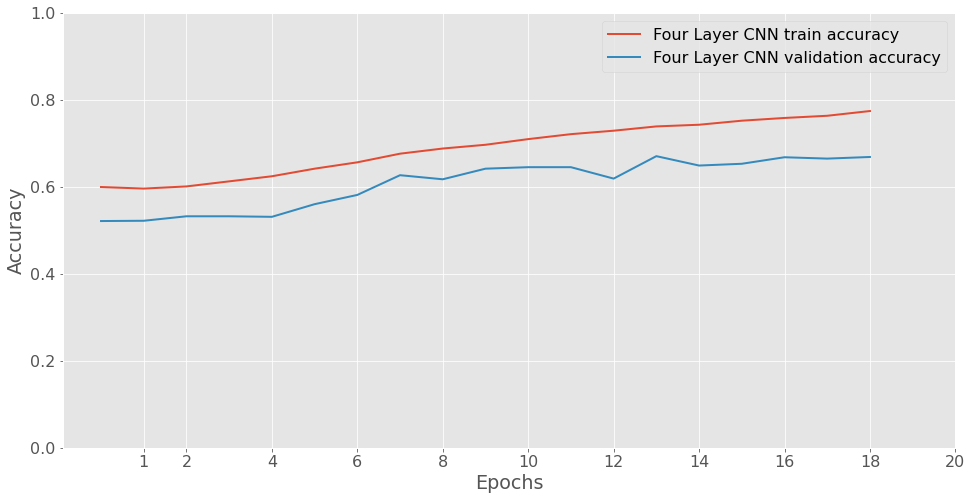

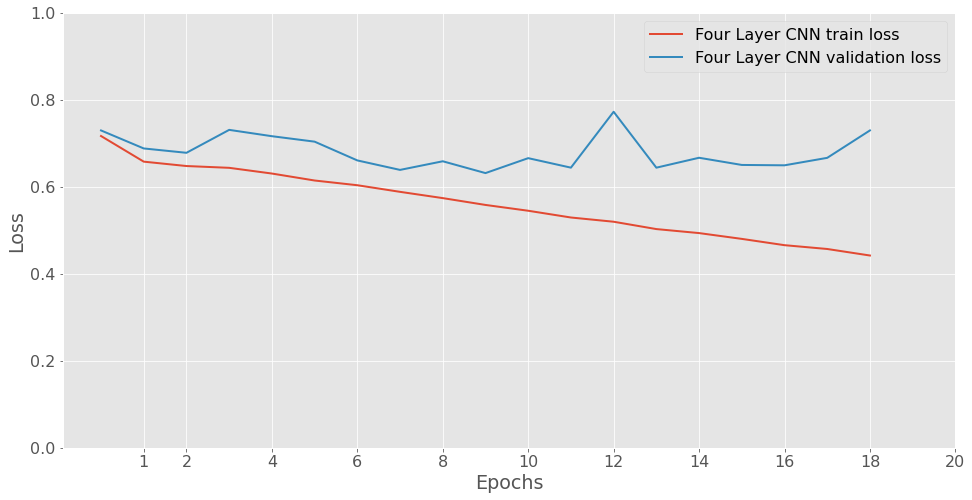

In [42]:
model_2.load_weights('best_weights_Four_Layer_CNN_Model.h5')

score_2 = model_2.evaluate(validset,verbose = 0)

print_results(hs_2, score_2)

plot_history(hs = {'Four Layer CNN': hs_2}, epochs = 20, metric = 'accuracy', ticks = 10)
plot_history(hs = {'Four Layer CNN': hs_2}, epochs = 20, metric = 'loss', ticks = 10)

##### *Remarks*

- Training stoped at **epoch 19** due to the early stopping. It is evident that, as the training progresses, the model begins to exhibit signs of overfitting.

- The model attains a validation accuracy of **67.1%**, which was acheived at **epoch 14**.

- As we can see we have managed to improve the the accuracy, but overfitting is still a big issue.